In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import torch
import numpy as np
import skimage.data, skimage.io


from matplotlib import pyplot as plt
from functools import partial
from torchmetrics.image import PeakSignalNoiseRatio as PSNR
from torchmetrics import MetricTracker

In [4]:
import sys
sys.path.append("..")


In [5]:
from alpine.models import Strainer
from alpine.models.utils import get_coords_nd, get_coords_spatial
from alpine.vis import pca

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/kv30/KV/ALL_INR_PROJECTS/ALPINE_LIBRARY/alpine/alpine/trainers/base.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
epochs = 2000
RES = 178
epochs_train = 5001

In [7]:
strainer_model = Strainer(in_features=2, out_features=3, hidden_features=RES, hidden_layers=6, num_decoders=10, num_shared_layers=5, outermost_linear=True).cuda()
strainer_model.compile()
print(strainer_model)
# strainer_model.compile(scheduler=partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda=lambda x:  0.1**min(x/1000,1)))

Strainer(
  (loss_function): MSELoss(
    (mse_loss): MSELoss()
  )
  (encoder): ModuleList(
    (0): Linear(in_features=2, out_features=178, bias=True)
    (1): Sine()
    (2): Linear(in_features=178, out_features=178, bias=True)
    (3): Sine()
    (4): Linear(in_features=178, out_features=178, bias=True)
    (5): Sine()
    (6): Linear(in_features=178, out_features=178, bias=True)
    (7): Sine()
    (8): Linear(in_features=178, out_features=178, bias=True)
    (9): Sine()
  )
  (decoder): ModuleList(
    (0-9): 10 x ModuleList(
      (0): Linear(in_features=178, out_features=3, bias=True)
    )
  )
)


In [8]:
coords = get_coords_spatial(RES, RES).cuda()[None,...]
print(coords.shape)

torch.Size([1, 178, 178, 2])


/home/kv30/anaconda3/envs/alpine_env/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
output = strainer_model(coords)
print(output['output'].shape)

torch.Size([1, 10, 178, 178, 3])


In [10]:

import glob
gt_train_imgs = []
for imfile in glob.glob('./data/train/*.npy'):
    img = np.load(imfile)
    img = skimage.transform.resize(img, (RES,RES))
    gt_train_imgs.append(torch.from_numpy(img).float().cuda()[None,...])
gt = torch.stack(gt_train_imgs, dim=1)
print(gt.shape)

torch.Size([1, 10, 178, 178, 3])


In [11]:
# criterion = lambda x,y: ((x['output'] - y['signal'])**2).mean(dim=[2,3,4]).sum()
# strainer_model.set_loss_function(criterion)

import torch.nn as nn

class StrainerLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = lambda x,y: ((x - y)**2).mean(dim=[2,3,4]).sum()

    def forward(self, x, y):
        out = x['output'].reshape(1,10,RES,RES, 3)
        signal = y['signal'].reshape(1,10,RES,RES, 3)
        
        return self.criterion(out, signal)
    
strainer_model.register_loss_function(StrainerLoss())


In [12]:
fit_val = strainer_model.fit_signal(input = coords, signal=gt, 
                                        n_iters=epochs_train, 
                                        enable_tqdm=True, 
                                        metric_trackers = {'psnr': MetricTracker(PSNR().to('cuda'))}, 
                                        return_features=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

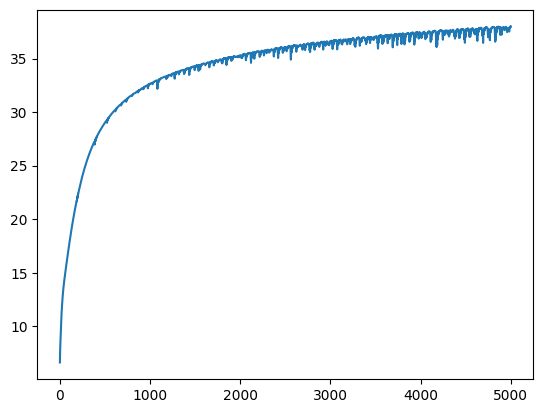

In [13]:
all_metrics = fit_val['metrics']
for _, m in all_metrics.items():
    plt.figure()
    plt.plot(m.numpy())
    plt.show()

In [15]:
strainer_test = Strainer(in_features=2, out_features=3, hidden_features=RES, hidden_layers=6, num_decoders=1, num_shared_layers=5, outermost_linear=True).cuda()
strainer_test.load_encoder_weights(strainer_model.encoder.state_dict())
strainer_test.compile()
print(strainer_test)
# strainer_model.compile(scheduler=partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda=lambda x:  0.1**min(x/1000,1)))

Strainer(
  (loss_function): MSELoss(
    (mse_loss): MSELoss()
  )
  (encoder): ModuleList(
    (0): Linear(in_features=2, out_features=178, bias=True)
    (1): Sine()
    (2): Linear(in_features=178, out_features=178, bias=True)
    (3): Sine()
    (4): Linear(in_features=178, out_features=178, bias=True)
    (5): Sine()
    (6): Linear(in_features=178, out_features=178, bias=True)
    (7): Sine()
    (8): Linear(in_features=178, out_features=178, bias=True)
    (9): Sine()
  )
  (decoder): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=178, out_features=3, bias=True)
    )
  )
)


In [16]:
import skimage.transform


gt_img_test = skimage.transform.resize(np.load("./data/23506.npy"), (RES,RES))
gt_test = torch.from_numpy(gt_img_test).float().cuda()[None,...]
print(gt_test.shape)

torch.Size([1, 178, 178, 3])


In [17]:
outputs_test = strainer_test.fit_signal(input = coords, signal=gt_test, n_iters=epochs, enable_tqdm=True, 
                                 metric_trackers = {'psnr': MetricTracker(PSNR().to('cuda'))}, 
                                return_features=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/kv30/anaconda3/envs/alpine_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 178, 178, 3])) that is different to the input size (torch.Size([1, 1, 178, 178, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


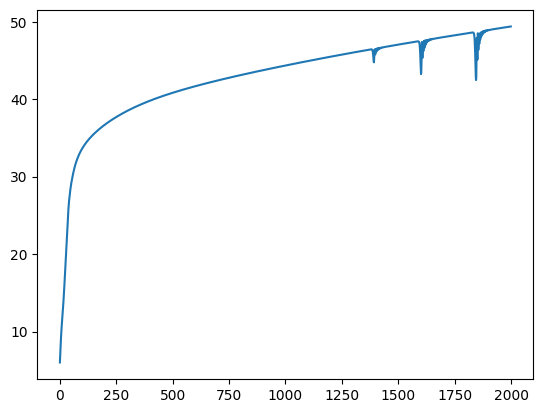

In [18]:
output_packet = strainer_test.render(coords, return_features=True)
all_metrics = outputs_test['metrics']
for _, m in all_metrics.items():
    plt.figure()
    plt.plot(m)
    plt.show()

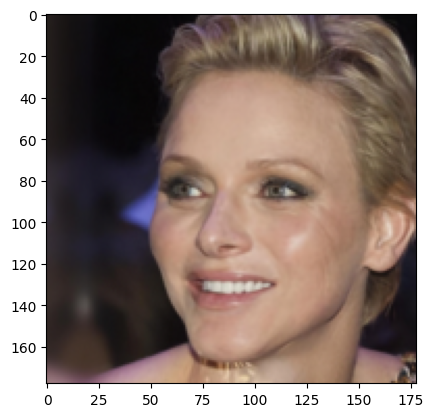

In [19]:
output = strainer_test.render(coords)['output']
plt.figure()
plt.imshow(output.cpu().detach().numpy()[0,0].reshape(RES,RES,3))
plt.show()